# Logistic Regression with a Neural Network

You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

In [1]:
!git clone https://github.com/SanVik2000/EE5179-Final.git

fatal: destination path 'EE5179-Final' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [3]:
def load_dataset():
    train_dataset = h5py.File('/content/EE5179-Final/Tutorial2/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/EE5179-Final/Tutorial2/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset containing:
    * a training set of images labeled as cat (y=1) or non-cat (y=0)
    * a test set of images labeled as cat or non-cat
    * each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = 0, it's a 'non-cat' picture.


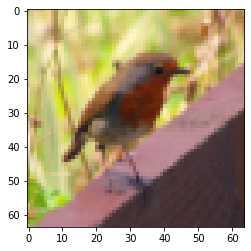

In [5]:
# Example of a picture
index =10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [6]:
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). 

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [7]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
train_set_y = train_set_y.reshape(train_set_y.shape[1], -1)
test_set_y = test_set_y.reshape(test_set_y.shape[1], -1)

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (209, 12288)
train_set_y shape: (209, 1)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (50, 1)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (209, 12288)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(209, 1)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(50, 12288)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(50, 1)</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [8]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (m_train, num_px \* num_px \* 3)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="https://raw.githubusercontent.com/SanVik2000/EE5179-Final/main/Tutorial2/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = x^{(i)} w^T + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Task02", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( x w^T + b) = \frac{1}{1 + e^{-(x w^T + b)}}$ to make predictions. Use np.exp().

In [9]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [10]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [11]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (1, dim) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((1, dim))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (1, dim))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [12]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0. 0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0. 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (1, num_px $\times$ num_px $\times$ 3).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(X w^T + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}(A-Y)^TX\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [13]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (1, num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples, 1)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(X, w.T) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (np.dot((A-Y).T, X))/m
    db = (np.sum(A-Y))/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [14]:
w, b, X, Y = np.array([[1.,2.]]), 2., np.array([[1.,2.],[-1.,3.],[4.,-3.2]]), np.array([[1],[0],[1]])
print("W Shape : " , w.shape)
print("X Shape : " , X.shape)
print("Y Shape : " , Y.shape, "\n")

grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

W Shape :  (1, 2)
X Shape :  (3, 2)
Y Shape :  (3, 1) 

dw = [[-1.69737532  2.45562263]]
db = 0.1997451187493734
cost = 3.9574190926537742


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [15]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (1, num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (number of examples, 1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [16]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 1000, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 2.46915585 -0.59357113]]
b = 1.322892868548117
dw = [[-0.05986524  0.00745058]]
db = -0.008994333545665381


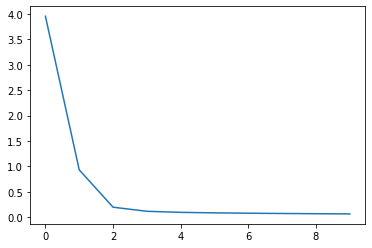

In [17]:
import matplotlib.pyplot as plt
plt.plot(costs)

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(X w^T + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [18]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (1, num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[0]
    Y_prediction = np.zeros((m, 1))
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(X, w.T) + b)           # Dimentions = (m, 1)
    ### END CODE HERE ###
    
    #### VECTORISED IMPLEMENTATION ####
    Y_prediction = (A >= 0.5) * 1.0
    
    assert(Y_prediction.shape == (m, 1))
    
    return Y_prediction

In [19]:
w = np.array([[2.46915585, -0.59357113]])
b = 1.322892868548117
X = np.array([[1.,-1.1],[-3.2,1.2],[2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1.]
 [0.]
 [1.]]


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [20]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (m_train, num_px * num_px * 3)
    Y_train -- training labels represented by a numpy array (vector) of shape (m_train, 1)
    X_test -- test set represented by a numpy array of shape (m_test, num_px * num_px * 3)
    Y_test -- test labels represented by a numpy array (vector) of shape (m_test, 1)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[1])
    print("W Shape : " , w.shape)
    print("X_Train Shape : " , X_train.shape)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 20000, learning_rate = 0.05, print_cost = True)

W Shape :  (1, 12288)
X_Train Shape :  (209, 12288)
Cost after iteration 0: 0.011789
Cost after iteration 100: 0.010170
Cost after iteration 200: 0.009613
Cost after iteration 300: 0.009189
Cost after iteration 400: 0.008839
Cost after iteration 500: 0.008536
Cost after iteration 600: 0.008267
Cost after iteration 700: 0.008026
Cost after iteration 800: 0.007805
Cost after iteration 900: 0.007602
Cost after iteration 1000: 0.007414
Cost after iteration 1100: 0.007238
Cost after iteration 1200: 0.007074
Cost after iteration 1300: 0.006919
Cost after iteration 1400: 0.006773
Cost after iteration 1500: 0.006634
Cost after iteration 1600: 0.006503
Cost after iteration 1700: 0.006378
Cost after iteration 1800: 0.006259
Cost after iteration 1900: 0.006145
Cost after iteration 2000: 0.006036
Cost after iteration 2100: 0.005931
Cost after iteration 2200: 0.005831
Cost after iteration 2300: 0.005735
Cost after iteration 2400: 0.005642
Cost after iteration 2500: 0.005553
Cost after iteration 260

**Expected Output**: 
<table style="width:40%"> 
    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. 

y = 1, you predicted that it is a "cat" picture.


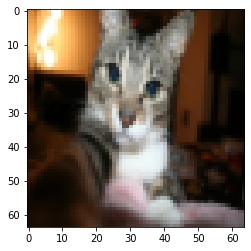

In [22]:
# Example of a picture that was wrongly classified.
index = 25
plt.imshow(test_set_x[index, :].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[index, 0]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][index][0])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

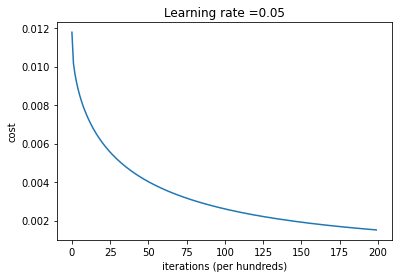

In [23]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 